In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    # %pip -q install clu
    %load_ext tensorboard
    from google.colab import drive

    drive.mount("/content/drive")
    %cd '/content/drive/MyDrive/Colab Notebooks/Hephaestus'
    import jax.tools.colab_tpu
    try:
        jax.tools.colab_tpu.setup_tpu()
    except RuntimeError:
        print("No TPU")

    %tensorboard \
        --logdir '/content/drive/MyDrive/Colab Notebooks/Hephaestus/Transformers/runs' \
        --load_fast=false

In [2]:
import os
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import chain

import hephaestus as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from flax import linen as nn
from flax import struct  # Flax dataclasses
from flax.training.early_stopping import EarlyStopping

# from flax.training import train_state
from jax import random
from jax.config import config
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange

# config.update("jax_debug_nans", True)

# Load and preprocess the dataset (assuming you have a CSV file)
df = pd.read_csv("./data/diamonds.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

/var/folders/rs/qflxwtyx6kvfj8jcqx5zm5hr0000gn/T/ipykernel_39588/2817891383.py:20: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
1,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
2,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
3,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
4,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


In [3]:
dataset = hp.TabularDS(df, target_column="price")

In [4]:
dataset.X_train_numeric[0].shape

(6,)

In [5]:
tsm = hp.TimeSeriesTransformer(dataset)

In [6]:
mtm = hp.MTM(dataset, n_heads=4)
trm = hp.TRM(dataset, n_heads=4)

In [18]:
batch_size = 12
test_num = dataset.X_train_numeric[0:batch_size, :]
test_num_mask = hp.mask_tensor(test_num, dataset)
test_cat = dataset.X_test_categorical[0:batch_size, :]
test_cat_mask = hp.mask_tensor(test_cat, dataset)

In [19]:
tsm_root_key = random.PRNGKey(44)
tsm_main_key, ts_params_key, ts_data_key = random.split(tsm_root_key, 3)
tsm_variables = tsm.init(
    tsm_main_key,
    test_cat_mask,
    test_num_mask,
)

In [20]:
tsm_out = tsm.apply(
    {"params": tsm_variables["params"]},
    test_cat_mask,
    test_num_mask,
)
tsm_out.shape

# print(mtm_out[0].shape, mtm_out[1].shape)
# mtm_out[0][0:2][0:2][0][0]

(1, 9, 64)

In [21]:
mtm_root_key = random.PRNGKey(42)
mtm_main_key, mtm_params_key, mtm_dropout_key = random.split(mtm_root_key, 3)

trm_root_key = random.PRNGKey(4242)
trm_main_key, trm_params_key, trm_dropout_key = random.split(trm_root_key, 3)


mtm_variables = mtm.init(
    mtm_params_key,
    test_cat_mask,
    test_num_mask,
)

trm_variables = trm.init(
    mtm_params_key,
    test_cat_mask,
    test_num_mask,
)

ic| models.py:220 in __call__()- out.shape: (12, 9, 64)
ic| models.py:224 in __call__()- categorical_out.shape: (12, 9, 33)
ic| models.py:226 in __call__()- out.shape: (12, 576)


In [22]:
# Tabulate the model
import numpy as np


t = nn.tabulate(
    mtm, mtm_main_key, console_kwargs={"force_terminal": False, "force_jupyter": True}
)(test_cat_mask, test_num_mask)
print(t)

ic| models.py:220 in __call__()- out.shape: (12, 9, 64)
ic| models.py:224 in __call__()- categorical_out.shape: (12, 9, 33)
ic| models.py:226 in __call__()- out.shape: (12, 576)


                                                    MTM Summary                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module             ┃ inputs                ┃ outputs            ┃ params                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│                       │ MTM                │ - int32[12,3]         │ - float32[12,9,33] │                       │
│                       │                    │ - float32[12,6]       │ - float32[12,6]    │                       │
├───────────────────────┼────────────────────┼───────────────────────┼────────────────────┼───────────────────────┤
│ TabTransformer_0      │ TabTransformer     │ categorical_inputs:   │ float32[12,9,64]   │                       │
│                       │                    │ int32[12,3]           │                    │                       │
│                       │                    │ numeric_inputs:       │                    │                       │
│                       │                    │ float32[12,6]         │                    │                       │
├───────────────────────┼────────────────────┼───────────────────────┼────────────────────┼───────────────────────┤
│ TabTransformer_0/emb… │ Embed              │ int32[12,9]           │ float32[12,9,64]   │ embedding:            │
│                       │                    │                       │                    │ float32[33,64]        │
│                       │                    │                       │                    │                       │
│                       │                    │                       │                    │ 2,112 (8.4 KB)        │
├───────────────────────┼────────────────────┼───────────────────────┼────────────────────┼───────────────────────┤
│ TabTransformer_0/Tra… │ TransformerBlock   │ k: float32[12,9,64]   │ float32[12,9,64]   │                       │
│                       │                    │ q: float32[12,9,64]   │                    │                       │
│                       │                    │ v: float32[12,9,64]   │                    │                       │
├───────────────────────┼────────────────────┼───────────────────────┼────────────────────┼───────────────────────┤
│ TabTransformer_0/Tra… │ MultiheadAttention │ - float32[12,9,64]    │ float32[12,9,64]   │                       │
│                       │                    │ - float32[12,9,64]    │                    │                       │
│                       │                    │ - float32[12,9,64]    │                    │                       │
│                       │                    │ - input_feed_forward: │                    │                       │
│                       │                    │ True                  │                    │                       │
│                       │                    │   mask: None          │                    │                       │
├───────────────────────┼────────────────────┼───────────────────────┼────────────────────┼───────────────────────┤
│ TabTransformer_0/Tra… │ Dense              │ float32[12,9,64]      │ float32[12,9,64]   │ bias: float32[64]     │
│                       │                    │                       │                    │ kernel:               │
│                       │                    │                       │                    │ float32[64,64]        │
│                       │                    │                       │                    │                       │
│                       │                    │                       │                    │ 4,160 (16.6 KB)       │
├───────────────────────┼────────────────────┼───────────────────────┼────────────────────┼───────────────────────┤
│ TabTransformer_0/Tra… │ Dense              │ float32[1

In [23]:
test_cat_mask.shape

(12, 3)

In [24]:
test_num_mask.shape

(12, 6)

In [25]:
mtm_out = mtm.apply(
    {"params": mtm_variables["params"]},
    test_cat_mask,
    test_num_mask,
)
print(mtm_out[0].shape, mtm_out[1].shape)
mtm_out[0][0:2][0:2][0][0]

ic| models.py:220 in __call__()- out.shape: (12, 9, 64)
ic| models.py:224 in __call__()- categorical_out.shape: (12, 9, 33)
ic| models.py:226 in __call__()- out.shape: (12, 576)


(12, 9, 33) (12, 6)


Array([-1.925451  ,  0.9473752 , -0.7886958 ,  0.49180594,  0.9317255 ,
        0.9636028 ,  0.1622773 ,  1.8987882 ,  1.805605  ,  0.5445205 ,
        0.99958235, -0.22567739, -0.24306007,  0.38095844, -2.7918332 ,
        1.908696  ,  0.83701736,  1.6220613 ,  0.68848205, -0.89211863,
        1.3067703 ,  0.06235248, -1.5469538 ,  0.35854468, -0.7101186 ,
        0.78688616, -0.6400558 , -1.82792   , -1.4679111 ,  0.13899805,
        0.8245328 ,  0.4718488 ,  0.01128174], dtype=float32)

In [26]:
dataset.n_tokens

33

In [14]:
dataset.n_tokens

33

In [ ]:
mtm_out[1].shape

(3, 6)

In [ ]:
regression_out = trm.apply(
    {"params": trm_variables["params"]},
    test_cat_mask,
    test_num_mask,
    # rngs={"dropout": jax.random.PRNGKey(43)}
)
regression_out

Array([[-0.05488636],
       [ 0.06849529],
       [-0.00230713]], dtype=float32)

In [ ]:
mtm_mi = hp.create_mtm_model_inputs(dataset, 0, 3)
# print(mi)
mtm_mi.categorical_targets

Array([[24, 21, 23,  3,  7,  8, 10, 11, 12],
       [14, 26, 29,  3,  7,  8, 10, 11, 12],
       [15, 32, 23,  3,  7,  8, 10, 11, 12]], dtype=int32)

In [ ]:
mtm.apply

<bound method Module.apply of MTM(
    # attributes
    dataset = TabularDS(target_column=['price'], seed=42, special_tokens=['[PAD]', '[NUMERIC_MASK]', '[MASK]'], cat_mask='[MASK]', cat_mask_token=2, n_tokens=33, n_cat_cols=3, n_numeric_cols=6, numeric_col_tokens=Array([ 3,  7,  8, 10, 11, 12], dtype=int32), category_columns=['cut', 'color', 'clarity'], col_tokens=['cut', 'color', 'clarity', 'carat', 'depth', 'table', 'x', 'y', 'z'], numeric_mask_token=Array(1, dtype=int32, weak_type=True), numeric_indices=Array([ 3,  7,  8, 10, 11, 12], dtype=int32), col_indices=Array([ 4,  5,  6,  3,  7,  8, 10, 11, 12], dtype=int32))
    d_model = 64
    n_heads = 4
)>

In [ ]:
hp.calculate_mlm_loss(mtm_variables["params"], mtm, mtm_mi)

{'total_loss': Array(5.231483, dtype=float32),
 'categorical_loss': Array(4.172841, dtype=float32),
 'numeric_loss': Array(1.058642, dtype=float32)}

In [1]:
mtm_train_state = hp.create_tsm_train_state(mtm_params_key, mtm_mi, dataset=dataset)
mtm_early_stopping = EarlyStopping(patience=20, min_delta=0.0001)
mtm_train_results = hp.train_mtm(
    model_state=mtm_train_state,
    model=mtm,
    dataset=dataset,
    model_name="MTM",
    epochs=500,
    batch_size=10_000,
    early_stopping=mtm_early_stopping,
)  #
# JIT 10/10 [00:33<00:00, 3.07s/it]  10/10 [00:32<00:00, 2.89s/it]
# No JIT 10/10 [00:57<00:00, 5.16s/it] 10/10 [00:58<00:00, 5.43s/it]

NameError: name 'hp' is not defined

In [ ]:
hp.calculate_mlm_loss(mtm_train_results["model_state"].params, mtm, mtm_mi)

{'total_loss': Array(0.08630353, dtype=float32),
 'categorical_loss': Array(0.08276676, dtype=float32),
 'numeric_loss': Array(0.00353678, dtype=float32)}

In [ ]:
res = hp.show_mask_pred(
    mtm_train_results["model_state"].params,
    mtm,
    1,
    dataset,
    probability=0.8,
    set="train",
)
pd.DataFrame.from_dict(res, orient="index")  # Fix this in the dicts

,cut,color,clarity,carat,depth,table,x,y,z
masked,Premium,F,SI2,0.215314,-1.151330,0.690462,NaN,0.442574,0.327715
actual,Premium,F,SI2,0.215314,-1.151330,0.690462,0.516017,0.442574,0.327715
pred,Premium,F,SI2,0.136776,-1.189039,0.759518,0.414256,0.356621,0.218626


In [ ]:
trm_mi = hp.create_trm_model_inputs(dataset, 0, 3)

In [ ]:
trm_train_state = hp.create_trm_train_state(trm_params_key, trm_mi, dataset=dataset)
train_results = hp.train_trm(
    model_state=trm_train_state,
    model=trm,
    dataset=dataset,
    model_name=f"TRM_No_FT",
    epochs=300,
    batch_size=10_000,
)  #

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
trm_train_state = hp.create_trm_train_state(
    trm_params_key,
    trm_mi,
    dataset=dataset,
    mtm_params=mtm_train_results["model_state"].params,
)
trm_early_stopping = EarlyStopping(patience=10, min_delta=0.0001)

train_results = hp.train_trm(
    model_state=trm_train_state,
    model=trm,
    dataset=dataset,
    model_name="TRM",
    epochs=100,
    batch_size=10_000,
    early_stopping=trm_early_stopping,
)  #

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
train_n_rows = [
    10,
    100,
    500,
    1000,
    2000,
    5000,
    10_000,
    20_000,
    30_000,
    len(dataset.X_train_numeric),
]
TRM_PATIENCE = 15
trm_train_results_no_pt = []
for rows in tqdm(train_n_rows):
    trm_train_state = hp.create_trm_train_state(trm_params_key, trm_mi, dataset=dataset)
    trm_early_stopping = EarlyStopping(patience=TRM_PATIENCE, min_delta=0.0001)

    train_results = hp.train_trm(
        model_state=trm_train_state,
        model=trm,
        dataset=dataset,
        model_name=f"TRM_No_Fine_Tune_{rows}",
        epochs=300,
        batch_size=10_000,
        n_rows=rows,
        early_stopping=trm_early_stopping,
    )
    train_loss = train_results["losses"]["train_loss"]
    test_loss = train_results["losses"]["test_loss"]
    best_test_loss = train_results["losses"]["best_test_loss"]
    trm_train_results_no_pt.append(
        {
            "rows": rows,
            "test_loss": test_loss,
            "train_loss": train_loss,
            "best_test_loss": best_test_loss,
        }
    )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


In [ ]:
trm_train_results_with_pt = []
for rows in tqdm(train_n_rows):
    trm_train_state = hp.create_trm_train_state(
        trm_params_key,
        trm_mi,
        dataset=dataset,
        mtm_params=mtm_train_results["model_state"].params,
    )
    trm_early_stopping = EarlyStopping(patience=TRM_PATIENCE, min_delta=0.0001)

    train_results = hp.train_trm(
        model_state=trm_train_state,
        model=trm,
        dataset=dataset,
        model_name=f"TRM_Fine_Tune_{rows}",
        epochs=300,
        batch_size=10_000,
        n_rows=rows,
        early_stopping=trm_early_stopping,
    )
    train_loss = train_results["losses"]["train_loss"]
    test_loss = train_results["losses"]["test_loss"]
    best_test_loss = train_results["losses"]["best_test_loss"]
    trm_train_results_with_pt.append(
        {
            "rows": rows,
            "test_loss": test_loss,
            "train_loss": train_loss,
            "best_test_loss": best_test_loss,
        }
    )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Early stopping triggered


In [ ]:
trm_train_results_no_pt

[{'rows': 10,
  'test_loss': 11312231.0,
  'train_loss': 2338085.25,
  'best_test_loss': 7400177.0},
 {'rows': 100,
  'test_loss': 1485653.0,
  'train_loss': 13970.8232421875,
  'best_test_loss': 1421054.375},
 {'rows': 500,
  'test_loss': 769781.625,
  'train_loss': 340326.8125,
  'best_test_loss': 724385.75},
 {'rows': 1000,
  'test_loss': 620886.0625,
  'train_loss': 239692.4375,
  'best_test_loss': 581046.375},
 {'rows': 2000,
  'test_loss': 476773.34375,
  'train_loss': 210542.15625,
  'best_test_loss': 473631.8125},
 {'rows': 5000,
  'test_loss': 361789.15625,
  'train_loss': 322129.71875,
  'best_test_loss': 360538.90625},
 {'rows': 10000,
  'test_loss': 407289.5,
  'train_loss': 348339.25,
  'best_test_loss': 385632.03125},
 {'rows': 20000,
  'test_loss': 329194.21875,
  'train_loss': 265299.3125,
  'best_test_loss': 326093.875},
 {'rows': 30000,
  'test_loss': 311632.3125,
  'train_loss': 270035.40625,
  'best_test_loss': 308980.71875},
 {'rows': 43152,
  'test_loss': 309177.5

In [ ]:
no_fine_tune_df = pd.DataFrame(trm_train_results_no_pt)
no_fine_tune_df["model"] = "No Fine Tune"
fine_tune_df = pd.DataFrame(trm_train_results_with_pt)
fine_tune_df["model"] = "Fine Tune"

results_df = pd.concat([no_fine_tune_df, fine_tune_df], axis=0)
results_df

,rows,test_loss,train_loss,best_test_loss,model
0,10,1.131223e+07,2.338085e+06,7.400177e+06,No Fine Tune
1,100,1.485653e+06,1.397082e+04,1.421054e+06,No Fine Tune
2,500,7.697816e+05,3.403268e+05,7.243858e+05,No Fine Tune
3,1000,6.208861e+05,2.396924e+05,5.810464e+05,No Fine Tune
4,2000,4.767733e+05,2.105422e+05,4.736318e+05,No Fine Tune
5,5000,3.617892e+05,3.221297e+05,3.605389e+05,No Fine Tune
6,10000,4.072895e+05,3.483392e+05,3.856320e+05,No Fine Tune
7,20000,3.291942e+05,2.652993e+05,3.260939e+05,No Fine Tune
8,30000,3.116323e+05,2.700354e+05,3.089807e+05,No Fine Tune
9,43152,3.091775e+05,2.908811e+05,2.995582e+05,No Fine Tune


In [ ]:
train_xgboost = True
if train_xgboost:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error

    # Load the diamonds dataset
    diamonds_data = pd.read_csv("./data/diamonds.csv")

    # Encode categorical features using LabelEncoder
    label_encoders = {}
    categorical_features = ["cut", "color", "clarity"]
    for feature in categorical_features:
        le = LabelEncoder()
        diamonds_data[feature] = le.fit_transform(diamonds_data[feature])
        label_encoders[feature] = le

    # Split the dataset into features (X) and target (y)
    X = diamonds_data.drop("price", axis=1)
    y = diamonds_data["price"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    def xgb_tester(train_set_size):
        xgb_regressor = XGBRegressor(
            n_estimators=100, learning_rate=0.1, random_state=42
        )
        xgb_regressor.fit(
            X_train[0:train_set_size],
            y_train[0:train_set_size],
        )

        y_test_pred = xgb_regressor.predict(X_test)
        y_train_pred = xgb_regressor.predict(X_train[0:train_set_size])
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_mse = mean_squared_error(y_train[0:train_set_size], y_train_pred)
        return {
            "rows": train_set_size,
            "best_test_loss": test_mse,
            "train_loss": train_mse,
        }

    xgb_losses = []
    for i in tqdm(train_n_rows):
        mse = xgb_tester(i)
        xgb_losses.append(mse)

    xgb_df = pd.DataFrame(xgb_losses)
    xgb_df["model"] = "XGBoost"

    # xgb_df
    results_df = pd.concat([results_df, xgb_df], axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
results_df["test_loss"] = results_df["test_loss"].astype(float)
results_df["best_test_loss"] = results_df["best_test_loss"].astype(float)

In [ ]:
results_df.head()

,rows,test_loss,train_loss,best_test_loss,model
0,10,1.131223e+07,2.338085e+06,7.400177e+06,No Fine Tune
1,100,1.485653e+06,1.397082e+04,1.421054e+06,No Fine Tune
2,500,7.697816e+05,3.403268e+05,7.243858e+05,No Fine Tune
3,1000,6.208861e+05,2.396924e+05,5.810464e+05,No Fine Tune
4,2000,4.767733e+05,2.105422e+05,4.736318e+05,No Fine Tune


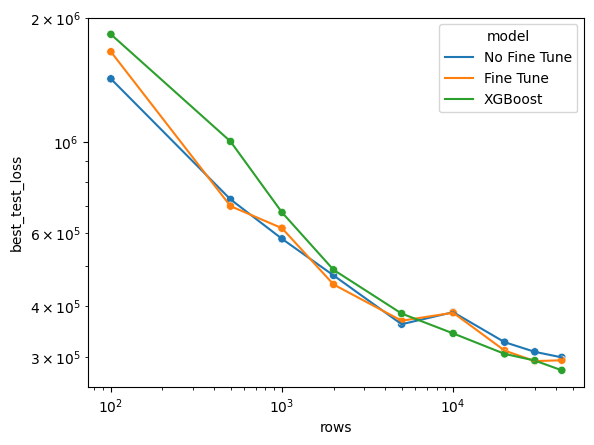

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df_plot = results_df.loc[results_df.rows > 10]
sns.lineplot(results_df_plot, x="rows", y="best_test_loss", hue="model")
sns.scatterplot(results_df_plot, x="rows", y="best_test_loss", hue="model", legend="")

plt.gca().set(yscale="log")
plt.gca().set(xscale="log")

# show the plot
plt.show()

In [ ]:
results_df.model.unique()

array(['No Fine Tune', 'Fine Tune', 'XGBoost'], dtype=object)

In [ ]:
loss_percent_df = results_df.pivot(
    index="rows", columns="model", values="best_test_loss"
).reset_index()
loss_percent_df["percent_improvement"] = (
    loss_percent_df["XGBoost"] - loss_percent_df["Fine Tune"]
) / loss_percent_df["XGBoost"]
loss_percent_df

model,rows,Fine Tune,No Fine Tune,XGBoost,percent_improvement
0,10,7.425748e+06,7.400177e+06,3.182655e+06,-1.333193
1,100,1.653240e+06,1.421054e+06,1.822236e+06,0.092741
2,500,6.976062e+05,7.243858e+05,1.001333e+06,0.303323
3,1000,6.165891e+05,5.810464e+05,6.733838e+05,0.084342
4,2000,4.502732e+05,4.736318e+05,4.886583e+05,0.078552
5,5000,3.676498e+05,3.605389e+05,3.826925e+05,0.039307
6,10000,3.844986e+05,3.856320e+05,3.425152e+05,-0.122574
7,20000,3.111120e+05,3.260939e+05,3.054610e+05,-0.018500
8,30000,2.933681e+05,3.089807e+05,2.943044e+05,0.003181
9,43152,2.947873e+05,2.995582e+05,2.786577e+05,-0.057883


(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 [Text(1.0, 0, '$\\mathdefault{10^{0}}$'),
  Text(10.0, 0, '$\\mathdefault{10^{1}}$'),
  Text(100.0, 0, '$\\mathdefault{10^{2}}$'),
  Text(1000.0, 0, '$\\mathdefault{10^{3}}$'),
  Text(10000.0, 0, '$\\mathdefault{10^{4}}$'),
  Text(100000.0, 0, '$\\mathdefault{10^{5}}$'),
  Text(1000000.0, 0, '$\\mathdefault{10^{6}}$')])

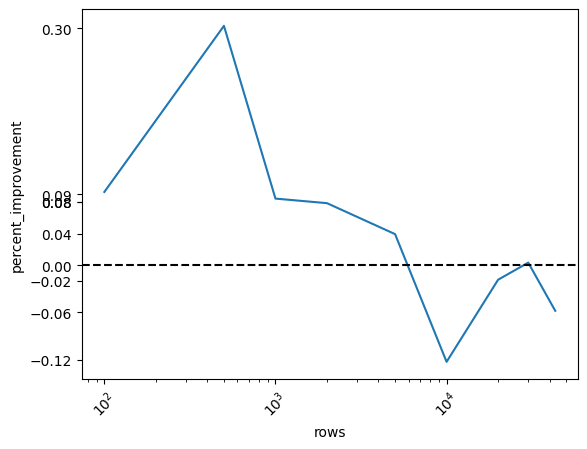

In [ ]:
ax = sns.lineplot(
    data=loss_percent_df.loc[loss_percent_df.rows > 10, :],
    x="rows",
    y="percent_improvement",
)
plt.axhline(y=0, color="black", linestyle="--")
ax.set_yticks(
    loss_percent_df.loc[loss_percent_df.rows > 10, "percent_improvement"].round(2)
)
ax.set_xticks(loss_percent_df["rows"])
ax.set_xscale("log")
# X lables at 45 degree angle
plt.xticks(rotation=45)